In [1]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
import seaborn
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk') # or paper

In [21]:
import os
#METRICS_FOLDER = '/sdf/group/neutrino/ldomine/chain/me/mpvmpr_012022/log_metrics1/'
METRICS_FOLDER = '/sdf/group/neutrino/ldomine/chain/me/mpvmpr_062022/log_metrics3/'

## UResNet

In [22]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         xlabel='Predicted label',
                         ylabel='True label',
                         xticklabels=['Shower', 'Track', 'Michel', 'Delta', 'LowE'],
                         yticklabels=['Shower', 'Track', 'Michel', 'Delta', 'LowE'],
                         show_colorbar=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig, ax = plt.subplots()
    #print(cm.shape)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if show_colorbar:
        ax.figure.colorbar(im, ax=ax)
    #labels = ['HIP', 'MIP', 'Shower', 'Delta', 'Michel']
    labels = yticklabels
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=labels,
           title=title,
           ylabel=ylabel,
           xlabel=xlabel,
           ylim=(-0.5, cm.shape[0]-0.5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [23]:
from numpy.linalg import norm
range = __builtins__.range

def confusion_matrix(metrics, num_classes):
    x = np.zeros((num_classes+1, num_classes+1))
    for c in range(num_classes):
        for c2 in range(num_classes):
            x[c][c2] = np.nansum(metrics['confusion_%d_%d' % (c, c2)])
        x[c][-1] = np.nansum(metrics['num_true_pix_class%d' % c]-metrics['num_true_deghost_pix_class%d' % c])
        x[num_classes][c] = np.nansum(metrics['ghost2nonghost_class%d' % c])
    x[num_classes, num_classes] = np.nansum((metrics['ghost2ghost'])*metrics['num_ghost_points'])
    return x / x.sum(axis=1, keepdims=True)

def confusion_matrix2(metrics, num_classes):
    x = np.zeros((num_classes, num_classes))
    for c in range(num_classes):
        for c2 in range(num_classes):
            x[c][c2] = np.nansum(metrics['confusion_%d_%d' % (c, c2)])
    return x / x.sum(axis=1, keepdims=True)

In [24]:
deghosting = pd.read_csv(os.path.join(METRICS_FOLDER, 'deghosting_metrics.csv'))

### Ghost vs nonghost confusion matrix

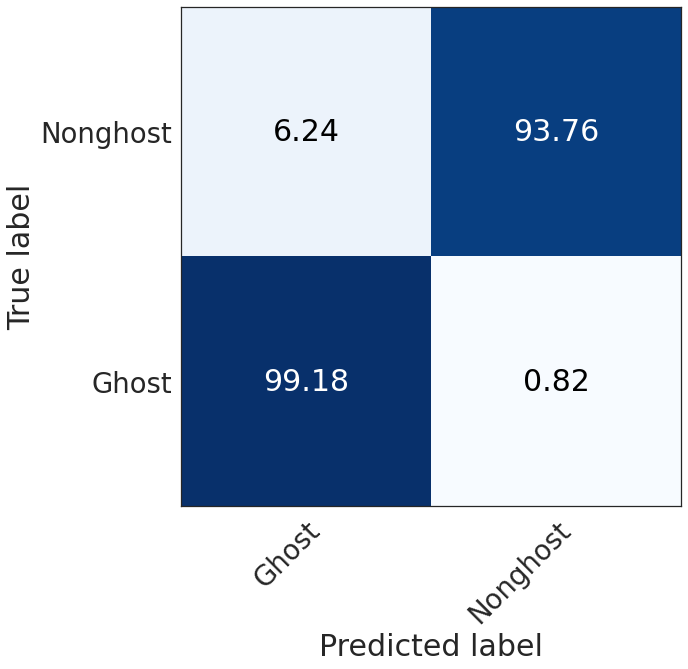

In [25]:
cm = np.empty((2, 2))

cm[0, 0] = (deghosting['ghost2ghost']*deghosting['num_ghost_points']).sum()
cm[0, 1] = (deghosting['num_ghost_points'] * (1 - deghosting['ghost2ghost'])).sum()
cm[1, 1] = (deghosting['nonghost2nonghost'] * deghosting['num_nonghost_points']).sum()
cm[1, 0] = (deghosting['num_nonghost_points']* (1 -deghosting['nonghost2nonghost'] )).sum()

cm[0, :] /= cm[0, :].sum()
cm[1, :] /= cm[1, :].sum()

seaborn.set(style="white", font_scale=2.5)
plot_confusion_matrix(np.array(cm*100), 
                      show_colorbar=False,
                     xticklabels=['Ghost', 'Nonghost'],
                     yticklabels=['Ghost', 'Nonghost'])

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

### Semantic confusion on (predicted + true) nonghost voxels

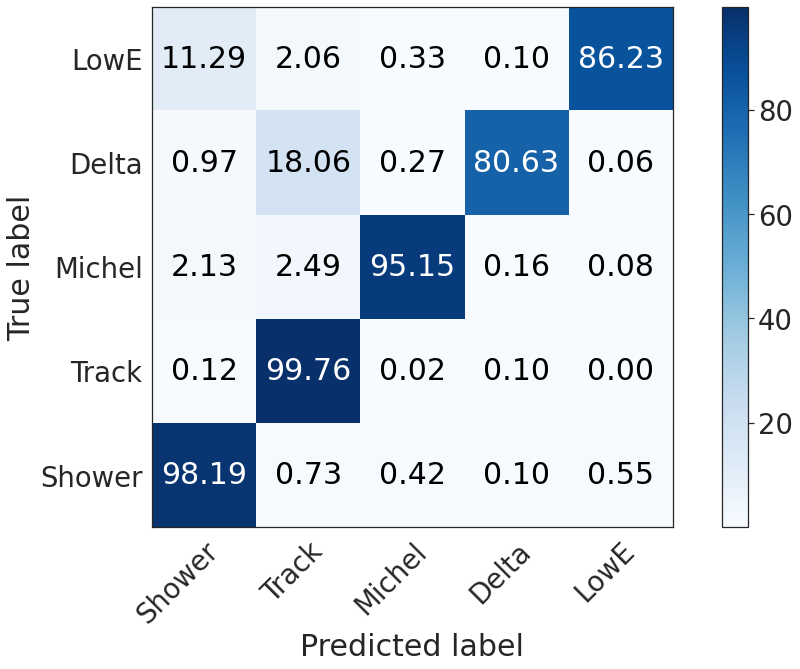

In [26]:
seaborn.set(style="white", font_scale=2.5)
plot_confusion_matrix(np.array(confusion_matrix2(deghosting, 5)*100))

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

### Global semantic confusion matrix (including ghosts)

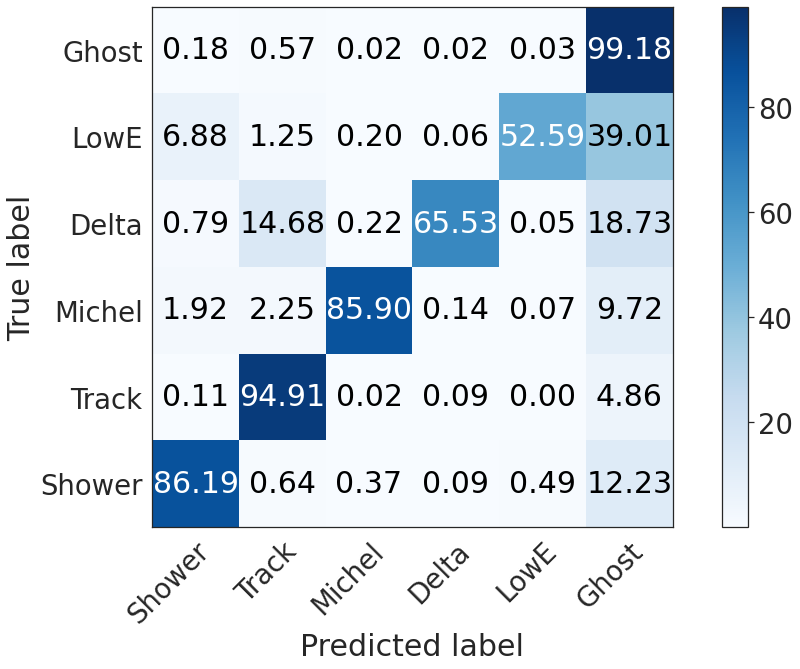

In [27]:
seaborn.set(style="white", font_scale=2.5)
plot_confusion_matrix(np.array(confusion_matrix(deghosting, 5)*100),
                     xticklabels = ['Shower', 'Track', 'Michel', 'Delta', 'LowE', 'Ghost'],
                     yticklabels = ['Shower', 'Track', 'Michel', 'Delta', 'LowE', 'Ghost'])

seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

## PPN

In [28]:
logs_gt = pd.read_csv(os.path.join(METRICS_FOLDER, "ppn-metrics-gt.csv"))
logs_pred = pd.read_csv(os.path.join(METRICS_FOLDER, "ppn-metrics-pred.csv"))

In [29]:
#label = 'distance_to_closest_pred_point'
distance_to_closest_pred = 'min_distance'
point_type = 'Class'
distance = 3 # px
#print('Fraction of true points that are not in attention layer = ', np.count_nonzero(logs_gt['attention']==0)/len(logs_gt))
# print('Fraction of Track true points with no predicted point within %dpx = ' % distance, np.count_nonzero((logs_gt[point_type] == 0) & (logs_gt[distance_to_closest_pred] > distance)) / np.count_nonzero(logs_gt[point_type] == 0))
# print('Fraction of Shower true points with no predicted point within %dpx = ' % distance, np.count_nonzero((logs_gt[point_type] == 1) & (logs_gt[distance_to_closest_pred] > distance)) / np.count_nonzero(logs_gt[point_type] == 1))
print('Fraction of true points with no predicted point within %dpx = ' % distance, np.count_nonzero((logs_gt[distance_to_closest_pred] > distance)) / logs_gt.shape[0])

Fraction of true points with no predicted point within 3px =  0.250598441764374


Median of pred. points within 3px of true point =  0.73424
Median of pred. points within 5px of true point =  0.77339


Text(0, 0.5, 'Points')

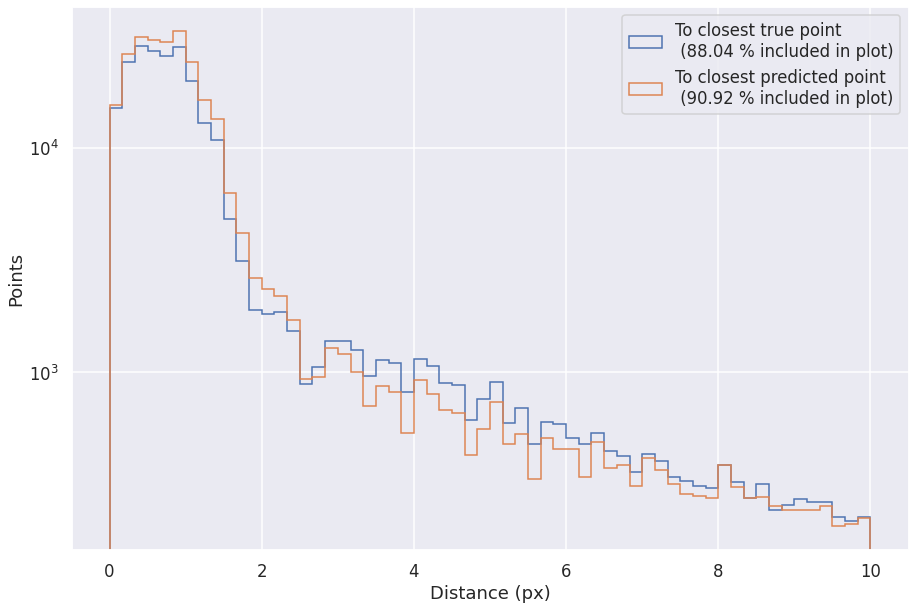

In [30]:
no_delta_pred = logs_pred['score_type_3'] < 0.5

#print("After removing delta points, keeping:", np.count_nonzero(no_delta_pred)/no_delta_pred.shape[0])

r = [0, 10]
bins = 60 #25
f= plt.figure()

fraction1 = np.count_nonzero(logs_pred[no_delta_pred]['min_distance']<r[1])/len(logs_pred[no_delta_pred])
plt.hist(logs_pred[no_delta_pred]['min_distance'], range=r, bins=bins, histtype='step', label='To closest true point \n (%.2f %% included in plot)' % (fraction1*100))

#print("Fraction of predicted points included in plot = ", fraction1)
print("Median of pred. points within 3px of true point = ", np.median(logs_pred[no_delta_pred]['min_distance'][logs_pred[no_delta_pred]['min_distance']<3]))
print("Median of pred. points within 5px of true point = ", np.median(logs_pred[no_delta_pred]['min_distance'][logs_pred[no_delta_pred]['min_distance']<5]))

no_delta_gt = logs_gt['Class'] != 3
fraction2 =  np.count_nonzero(logs_gt[no_delta_gt]['min_distance']<r[1])/len(logs_gt[no_delta_gt])
plt.hist(logs_gt[no_delta_gt]['min_distance'], range=r, bins=bins, histtype='step', label='To closest predicted point \n (%.2f %% included in plot)' % (fraction2*100))

plt.legend()
plt.yscale('log')
plt.xlabel('Distance (px)')
plt.ylabel('Points')
#print("Fraction of true points included in plot = ", fraction2)

## GraphSpice

In [31]:
graph_spice = pd.read_csv(os.path.join(METRICS_FOLDER, "graph-spice-metrics.csv"))

Text(0.5, 0, 'Track Fragment Clustering Metric')

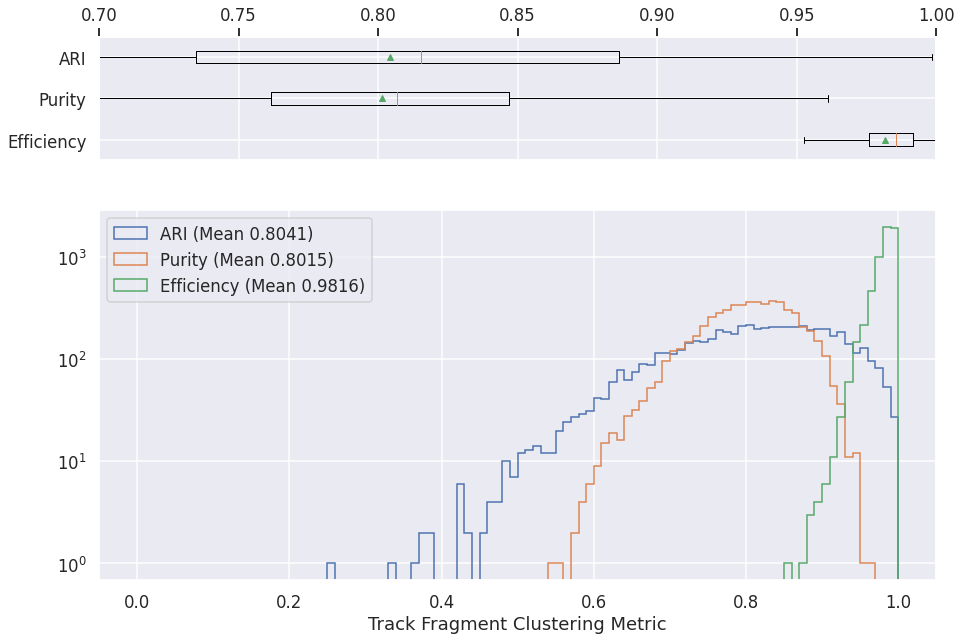

In [32]:
nonzero_ari = graph_spice['ARI'] > 0
# print(np.count_nonzero(nonzero_ari)/len(graph_spice))
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]})

axs[0].boxplot([
    graph_spice['efficiency'][nonzero_ari],
    graph_spice['purity'][nonzero_ari],
    graph_spice['ARI'][nonzero_ari]
    ], vert=False, showmeans=True,showfliers=False)
axs[0].set_yticklabels(['Efficiency', 'Purity', 'ARI'])
axs[0].set_xlim(0.7, 1.)
axs[0].xaxis.tick_top()

axs[1].hist(graph_spice['ARI'][nonzero_ari], range=[0, 1], bins=100, label='ARI (Mean %.4f)' % graph_spice['ARI'][nonzero_ari].mean(), histtype='step')
axs[1].hist(graph_spice['purity'][nonzero_ari], range=[0, 1], bins=100, label='Purity (Mean %.4f)' % graph_spice['purity'][nonzero_ari].mean(), histtype='step')
axs[1].hist(graph_spice['efficiency'][nonzero_ari], range=[0, 1], bins=100, label='Efficiency (Mean %.4f)' % graph_spice['efficiency'][nonzero_ari].mean(), histtype='step')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xlabel('Track Fragment Clustering Metric')

## Shower Grappa clustering

Text(0.5, 0, 'Shower Clustering Metric')

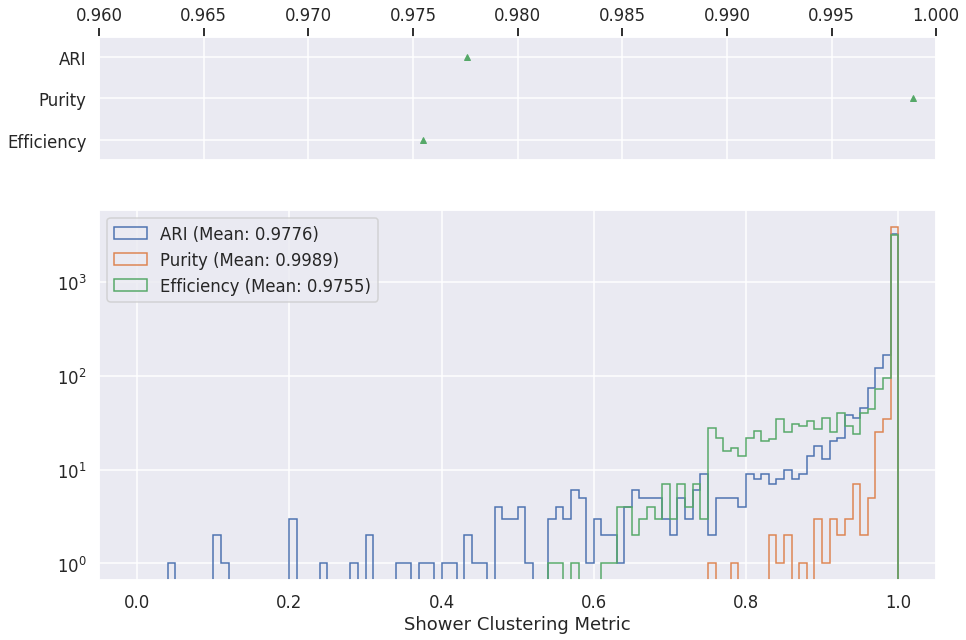

In [38]:
logs = pd.read_csv(os.path.join(METRICS_FOLDER, "cluster-gnn-metrics-shower.csv"))

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]})

axs[0].boxplot([
    logs['eff'][logs['ari']>0],
    logs['pur'][logs['ari']>0],
    logs['ari'][logs['ari']>0]
    ], vert=False, showmeans=True,showfliers=False)
axs[0].set_yticklabels(['Efficiency', 'Purity', 'ARI', ])
axs[0].set_xlim(0.96, 1.)
axs[0].xaxis.tick_top()

axs[1].hist(logs['ari'][logs['ari']>0], label="ARI (Mean: %.4f)" % logs['ari'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
axs[1].hist(logs['pur'][logs['ari']>0], label="Purity (Mean: %.4f)" % logs['pur'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
axs[1].hist(logs['eff'][logs['ari']>0], label="Efficiency (Mean: %.4f)" % logs['eff'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
plt.legend(loc='upper left')
plt.yscale('log')
plt.xlabel('Shower Clustering Metric')

In [39]:
print("Accuracy of primary shower fragment identification: %.1f%%" % (logs['primary_accuracy'].mean()*100))

Accuracy of primary shower fragment identification: 68.6%


## Track Grappa clustering

Text(0.5, 0, 'Track Clustering Metric')

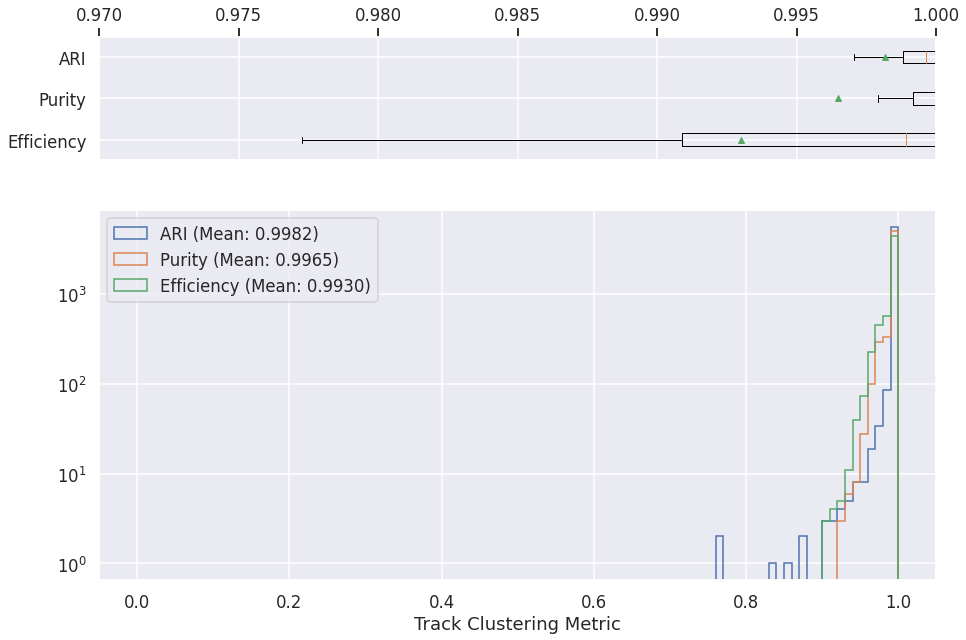

In [40]:
logs = pd.read_csv(os.path.join(METRICS_FOLDER, "cluster-gnn-metrics-track.csv"))

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]})

axs[0].boxplot([
    logs['eff'][logs['ari']>0],
    logs['pur'][logs['ari']>0],
    logs['ari'][logs['ari']>0]
    ], vert=False, showmeans=True,showfliers=False)
axs[0].set_yticklabels(['Efficiency', 'Purity', 'ARI', ])
axs[0].set_xlim(0.97, 1.)
axs[0].xaxis.tick_top()

axs[1].hist(logs['ari'][logs['ari']>0], label="ARI (Mean: %.4f)" % logs['ari'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
axs[1].hist(logs['pur'][logs['ari']>0], label="Purity (Mean: %.4f)" % logs['pur'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
axs[1].hist(logs['eff'][logs['ari']>0], label="Efficiency (Mean: %.4f)" % logs['eff'][logs['ari']>0].mean(), histtype='step', range=[0, 1], bins=100)
plt.legend(loc='upper left')
plt.yscale('log')
plt.xlabel('Track Clustering Metric')

## Interaction Grappa clustering

Text(0.5, 0, 'Interaction Clustering Metric')

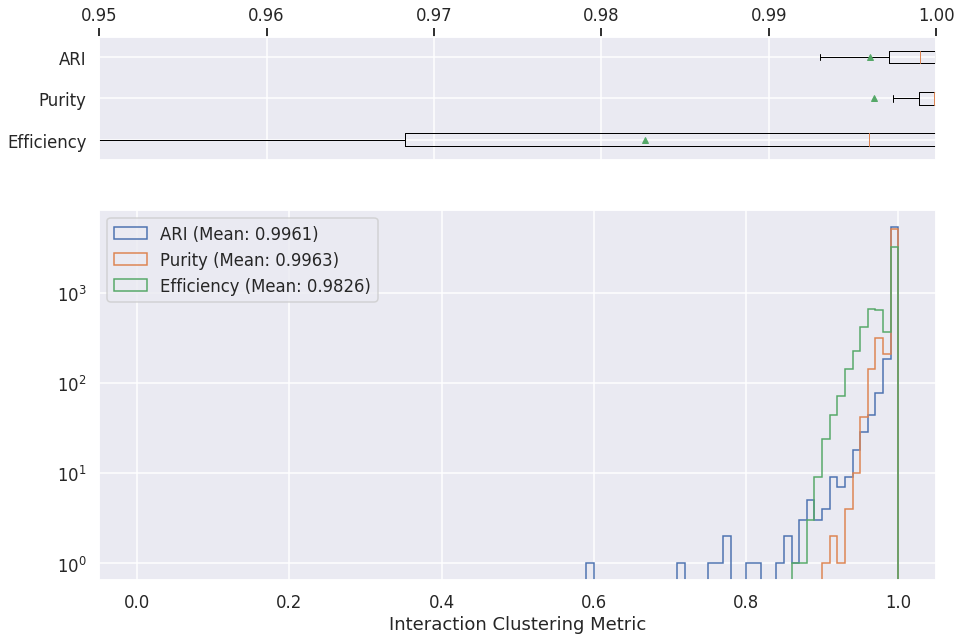

In [41]:
logs = pd.read_csv(os.path.join(METRICS_FOLDER, "cluster-gnn-metrics-inter.csv"))

fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [1, 3]})

axs[0].boxplot([
    logs['eff'][logs['ari']>0],
    logs['pur'][logs['ari']>0],
    logs['ari'][logs['ari']>0]
    ], vert=False, showmeans=True,showfliers=False)
axs[0].set_yticklabels(['Efficiency', 'Purity', 'ARI', ])
axs[0].set_xlim(0.95, 1.)
axs[0].xaxis.tick_top()

axs[1].hist(logs['ari'][logs['ari']>0], label="ARI (Mean: %.4f)" % logs['ari'].mean(), histtype='step', range=[0, 1], bins=100)
axs[1].hist(logs['pur'][logs['ari']>0], label="Purity (Mean: %.4f)" % logs['pur'].mean(), histtype='step', range=[0, 1], bins=100)
axs[1].hist(logs['eff'][logs['ari']>0], label="Efficiency (Mean: %.4f)" % logs['eff'].mean(), histtype='step', range=[0, 1], bins=100)
plt.legend(loc='upper left')
plt.yscale('log')
plt.xlabel('Interaction Clustering Metric')

In [42]:
print("Accuracy of primary particle identification: %.2f%%" % logs['primary_accuracy'].mean())

Accuracy of primary particle identification: -1.00%


## PID

In [43]:
def plot_confusion_matrix(cm,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         xlabel='Predicted label',
                         ylabel='True label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #xticklabels = ['HIP', 'MIP', 'Shower', 'Delta', 'Michel']
    
    xticklabels = ['Photon', '$e$', '$\mu$', '$\pi$', 'Proton']
    if cm.shape[1] > 5:
        xticklabels.append('Ghost')
    #     if cm.shape[1] > 5:
    #         xticklabels.append('Ghost')
        
    fig, ax = plt.subplots()
    print(cm.shape)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #labels = ['HIP', 'MIP', 'Shower', 'Delta', 'Michel']
    labels = ['Photon', '$e$', '$\mu$', '$\pi$', 'Proton']
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=labels,
           title=title,
           ylabel=ylabel,
           xlabel=xlabel,
           ylim=(-0.5, cm.shape[0]-0.5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [44]:
from numpy.linalg import norm
def confusion_matrix(kinematics, num_classes):
    x = np.zeros((num_classes, num_classes))
    for c in range(num_classes):
        for c2 in range(num_classes):
            x[c][c2] =  np.count_nonzero((kinematics['true_type'] == c) & (kinematics['pred_type'] == c2) )
        #x[c][-1] = np.nansum(metrics['num_true_pix_class%d' % c]-metrics['num_true_deghost_pix_class%d' % c])
    return x / x.sum(axis=1, keepdims=True)

In [45]:
kinematics = pd.read_csv(os.path.join(METRICS_FOLDER, "pid-metrics.csv"))

(5, 5)


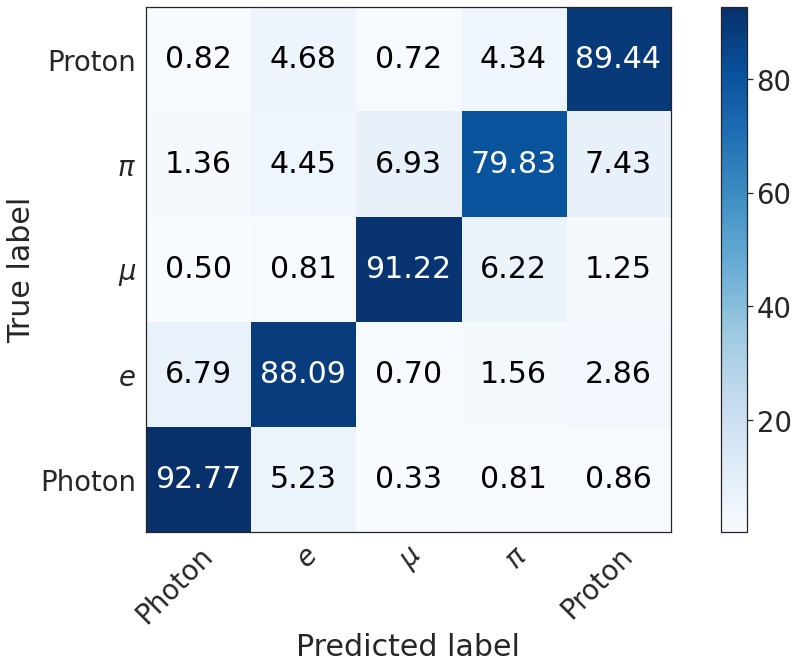

In [46]:
seaborn.set(style="white", font_scale=2.5)
plot_confusion_matrix(np.array(confusion_matrix(kinematics, 5)*100))
#plt.savefig("confusion_matrix.png", transparent=True)
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

## Vertex heuristic performance

In [47]:
def plot_vtx_resolution(vtx_candidates, label=''):
    vtx_predicted = (vtx_candidates['vtx_resolution'] >= 0)
    min_primaries = (vtx_candidates['num_primaries'] > 1) #& (vtx_candidates['num_pix'] > 20)
    nu_filter = (vtx_candidates['is_nu'] > 0)
    r = [0, 20]

    vtx_filter = vtx_predicted & min_primaries & nu_filter

    no_prediction = np.count_nonzero(~vtx_predicted & min_primaries & nu_filter)/np.count_nonzero(min_primaries & nu_filter) * 100
    outside = np.count_nonzero(vtx_filter & (vtx_candidates['vtx_resolution'] > r[1]))/np.count_nonzero(vtx_filter)*100
    mean_range = [0, 3]
    mean = vtx_candidates['vtx_resolution'][vtx_filter][(vtx_candidates['vtx_resolution'][vtx_filter] > mean_range[0]) & (vtx_candidates['vtx_resolution'][vtx_filter] < mean_range[1])].mean()
    plt.hist(vtx_candidates['vtx_resolution'][vtx_filter]*0.3, range=r, bins=50, histtype='step', label='%s (Mean = %.2f | %.1f %% outside of range | %.1f %% w/o prediction)' % (label, mean, outside, no_prediction))
    plt.xlabel('Vertex resolution (cm)')
    plt.ylabel('Predicted interactions')

    plt.gca().axvspan(mean_range[0], mean_range[1], alpha=0.1)
    plt.legend()


In [48]:
vtx_candidates = pd.read_csv(os.path.join(METRICS_FOLDER, "vertex-candidates.csv"))

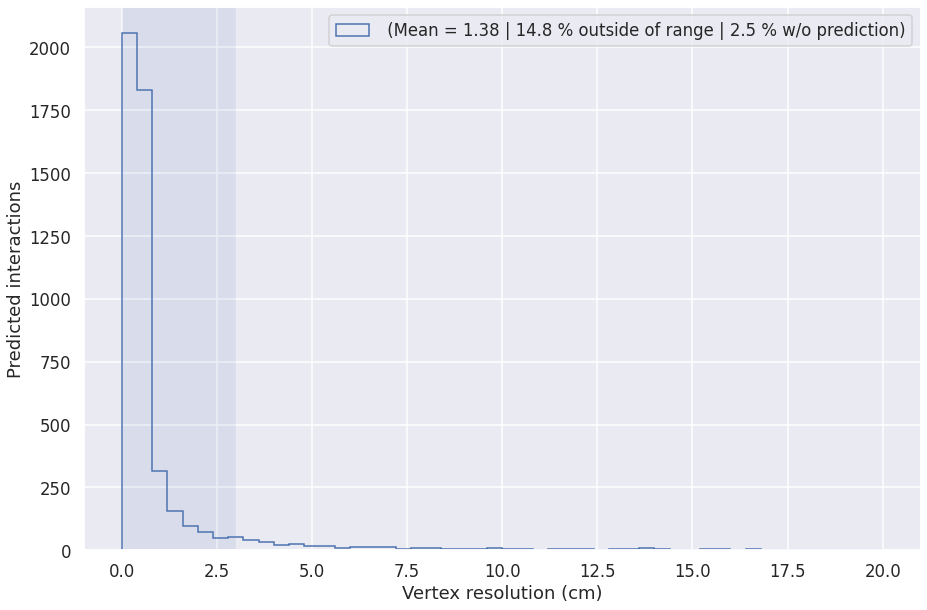

In [49]:
plot_vtx_resolution(vtx_candidates)